# Exploration of Scotland image location data 

- Data collected by DSTL and hosted on Kaggle 

Within this notebook we'll start by performing some basic extraction of EXIF formatted data from all the images within the dataset. Following this, we'll explore various meta-data features, which allows us to plot the locations of all images taken on a map of Scotland. Subsequently, we'll form a dataset of images organised in terms of the town / city the image was taken. 

The intention of this work is to evaluate the feasibility of using a deep neural convolutional neural network to classify the town / city of an image based entirely on its visual features.

In [147]:
import folium
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotly.express as px
import reverse_geocode
import seaborn as sns
import shutil

from keras.callbacks import ModelCheckpoint
from keras.layers import MaxPooling2D, Conv2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from pathlib import Path
from PIL.ExifTags import TAGS, GPSTAGS
from PIL import Image

from skimage.feature import hog
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import exposure

from sklearn.model_selection import train_test_split

In [148]:
# if using gpu - confirm
import tensorflow as tf
tf.test.gpu_device_name()

''

Set random seed for the work used throughout this notebook:

In [149]:
np.random.seed(1)
tf.random.set_seed(1)

## 1. Dataset exploration and pre-processing

### Extraction of EXIF metadata from images to form a dataset of metadata

In [150]:
[x[0] for x in os.walk('Images')]

['Images',
 'Images/200-299',
 'Images/100-199',
 'Images/500-599',
 'Images/600-699',
 'Images/700-735',
 'Images/300-399',
 'Images/000-099',
 'Images/400-499']

In [151]:
def extract_exif(filename):
    """ Extract img EXIF data """
    image_file = Image.open(filename)
    image_file.verify()
    return image_file._getexif()


def extract_exif_labelled(exif_data):
    """ Extract EXIF data with formatted labels """
    labelled_data = {}
    for (key, val) in exif_data.items():
        labelled_data[TAGS.get(key)] = val
    return labelled_data


def extract_geotags(exif_data):
    """ Obtain better formatted geotag data """
    if not exif_data:
        raise ValueError("EXIF metadata not found.")
    geotags = {}
    for (idx, geotag) in TAGS.items():
        if geotag == 'GPSInfo':
            if idx not in exif_data:
                raise ValueError("No EXIF geotagging found")
            for (key, val) in GPSTAGS.items():
                if key in exif_data[idx]:
                    geotags[val] = exif_data[idx][key]
    return geotags


def lat_long_alt_from_geotag(geotags):
    """ Obtain decimal lat, long and altitude from geotags """
    lat = dms_to_decimal(geotags['GPSLatitudeRef'], geotags['GPSLatitude'])
    long = dms_to_decimal(geotags['GPSLongitudeRef'], geotags['GPSLongitude'])
    
    # obtain altitude data and process, if it exists
    altitude = None
    try:
        alt = geotags['GPSAltitude']
        altitude = alt[0] / alt[1]
        
        # multiple by -1 if below sea level
        if geotags['GPSAltitudeRef'] == 1: 
            altitude *= -1
    except KeyError:
        altitude = 0
  
    return lat, long, altitude


def dms_to_decimal(lat_long_ref, deg_min_sec):
    """ Convert degrees, minutes, seconds tuples into decimal
        lat and lon values. Given to 5 decimal places - more 
        than sufficient for commercial GPS """
    
    degrees = deg_min_sec[0][0] / deg_min_sec[0][1]
    minutes = deg_min_sec[1][0] / deg_min_sec[1][1] / 60.0
    seconds = deg_min_sec[2][0] / deg_min_sec[2][1] / 3600.0
    
    if lat_long_ref in ['S', 'W']:
        degrees = -degrees
        minutes = -minutes
        seconds = -seconds
        
    return round(degrees + minutes + seconds, 5)

#### Choose an image as an example, and display metadata

In [152]:
example_filename = 'Images/300-399/322.jpg'
exif = extract_exif(example_filename)
labeled = extract_exif_labelled(exif)

for key, val in labeled.items():
    print(f"{key} : {val}")

ImageWidth : 4032
ImageLength : 3024
GPSInfo : {1: 'N', 2: ((57, 1), (16, 1), (98125, 10646)), 3: 'W', 4: ((4, 1), (28, 1), (21815, 1123)), 5: b'\x00', 6: (16000, 100), 7: ((18, 1), (32, 1), (1, 1)), 29: '2019:03:19'}
ResolutionUnit : 2
ExifOffset : 274
Make : LGE
Model : Nexus 5X
Software : bullhead-user 8.1.0 OPM7.181205.001 5080180 release-keys
Orientation : 1
DateTime : 2019:03:19 18:32:07
YCbCrPositioning : 1
XResolution : (72, 1)
YResolution : (72, 1)
ExifVersion : b'0220'
ComponentsConfiguration : b'\x01\x02\x03\x00'
ShutterSpeedValue : (-590, 100)
DateTimeOriginal : 2019:03:19 18:32:07
DateTimeDigitized : 2019:03:19 18:32:07
ApertureValue : (200, 100)
BrightnessValue : (0, 100)
ExposureBiasValue : (0, 6)
SubjectDistance : (568, 1000)
MeteringMode : 0
Flash : 0
FocalLength : (4670, 1000)
ColorSpace : 1
ExifImageWidth : 4032
ExifInteroperabilityOffset : 780
SceneCaptureType : 0
SubsecTime : 061115
SubsecTimeOriginal : 061115
SubsecTimeDigitized : 061115
ExifImageHeight : 3024
Sub

In [153]:
geo_data = extract_geotags(exif)

for key, val in geo_data.items():
    print(f"{key} : {val}")

GPSLatitudeRef : N
GPSLatitude : ((57, 1), (16, 1), (98125, 10646))
GPSLongitudeRef : W
GPSLongitude : ((4, 1), (28, 1), (21815, 1123))
GPSAltitudeRef : b'\x00'
GPSAltitude : (16000, 100)
GPSTimeStamp : ((18, 1), (32, 1), (1, 1))
GPSDateStamp : 2019:03:19


In [154]:
coords = lat_long_alt_from_geotag(geo_data)
print(coords)

(57.26923, -4.47206, 160.0)


#### Extract GPS Location and other details from all images and form dataset

Before doing this, ensure all .DS_Store files are removed recursively from all directories. This can be done on MacOS on the terminal of the chosen directory using: find . -name "*.DS_Store" -type f -delete

In [155]:
img_name, img_path = [], []
latitudes, longitudes, altitudes = [], [], []
img_width, img_height = [], []
makes, models = [], []
time_dates = []

for dirname, _, filenames in os.walk('Images/'):
    for filename in filenames:
        
        file_path = os.path.join(dirname, filename)
        
        exif_data = extract_exif(file_path)
        exif_labels = extract_exif_labelled(exif_data)
        geo_data = extract_geotags(exif_data)
        lat, long, alt = lat_long_alt_from_geotag(geo_data)
        
        img_name.append(filename)
        img_path.append(file_path)
        latitudes.append(lat)
        longitudes.append(long)
        altitudes.append(alt)
        img_width.append(exif_labels.get('ImageWidth', 0))
        img_height.append(exif_labels.get('ImageLength', 0))
        makes.append(exif_labels.get('Make', 'Unknown'))
        models.append(exif_labels.get('Model', 'Unknown'))
        time_dates.append(exif_labels.get('DateTime', 0))

#### Determine city for each coordinate

In [156]:
# reverse geocode our coordinates for the city
coord_pairs = [(lat,long) for lat, long in zip(latitudes, longitudes)]
cities = [x['city'] for x in reverse_geocode.search(coord_pairs)]

#### Form dataframe for all our imagery metadata

In [157]:
metadata_df = pd.DataFrame({ 'filename' : img_name, 'filepath' : img_path, 
                             'img_width' : img_width, 'img_height' : img_height, 
                             'make' :makes, 'model' : models,
                             'latitude' : latitudes, 'longitude' : longitudes, 
                             'altitude' : altitudes, 'time_date' : time_dates,
                             'city' : cities})

In [158]:
metadata_df.head()

,filename,filepath,img_width,img_height,make,model,latitude,longitude,altitude,time_date,city
0,228.jpg,Images/200-299/228.jpg,4032,3024,LGE,Nexus 5X,56.81761,-5.10815,0.0,2019:03:19 16:54:02,Caol
1,214.jpg,Images/200-299/214.jpg,0,0,LGE,Nexus 5X,56.81566,-5.11532,0.0,2020:02:12 18:01:07,Caol
2,200.jpg,Images/200-299/200.jpg,4032,3024,LGE,Nexus 5X,56.63213,-4.78969,403.0,2019:03:19 16:04:23,Caol
3,201.jpg,Images/200-299/201.jpg,4032,3024,LGE,Nexus 5X,56.64304,-4.82693,351.0,2019:03:19 16:05:49,Caol
4,215.jpg,Images/200-299/215.jpg,4032,3024,LGE,Nexus 5X,56.81574,-5.11515,58.0,2019:03:19 16:42:30,Caol


#### Quick visualisation of dataset features for interest

Altitude of the images taken in the dataset:

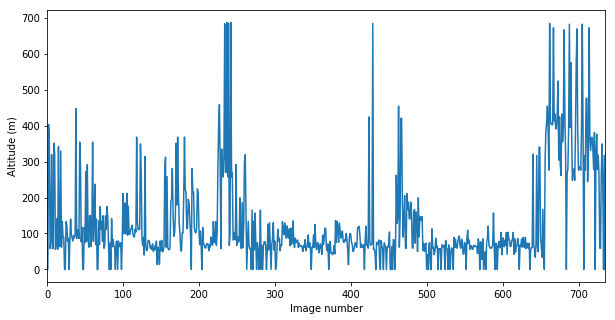

In [159]:
plt.figure(figsize=(10,5))
metadata_df['altitude'].plot()
plt.ylabel("Altitude (m)")
plt.xlabel("Image number")
plt.show()

Sort dataset by date and visualise change in altitude as each image was taken:

In [160]:
date_index_df = metadata_df.copy()
date_index_df['Date'] = pd.to_datetime(date_index_df['time_date'], format='%Y:%m:%d %H:%M:%S')
date_index_df.sort_values(by=['Date'], inplace=True, ascending=True)
date_index_df.reset_index(inplace=True, drop=True)

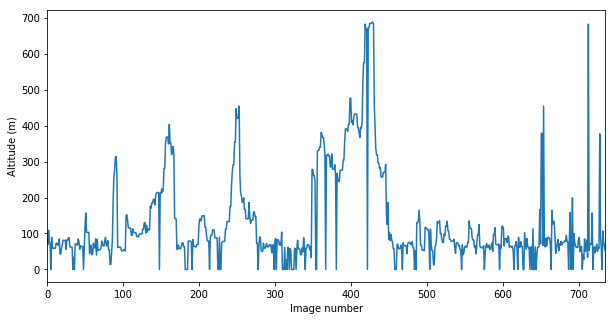

In [161]:
plt.figure(figsize=(10,5))
date_index_df['altitude'].plot()
plt.ylabel("Altitude (m)")
plt.xlabel("Image number")
plt.show()

Visualise the number of images taken in each town / city:

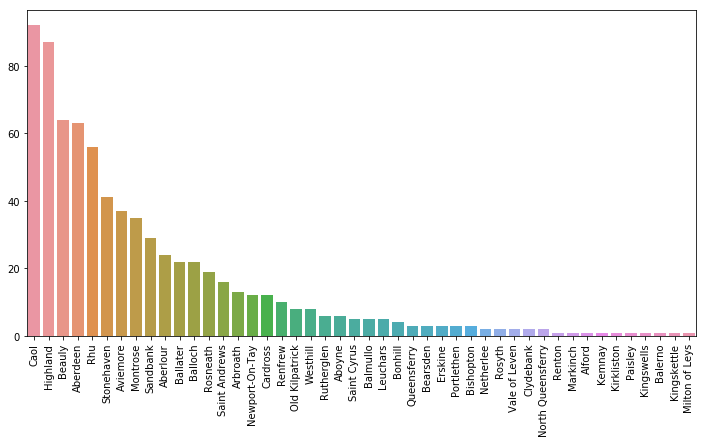

In [162]:
plt.figure(figsize=(12,6))
values = metadata_df['city'].value_counts()
sns.barplot(x = values.index.values, y = values.values)
plt.xticks(rotation=90)
plt.show()

Lets focus on just the top ten towns / cities that have a reasonable number of samples (20+):

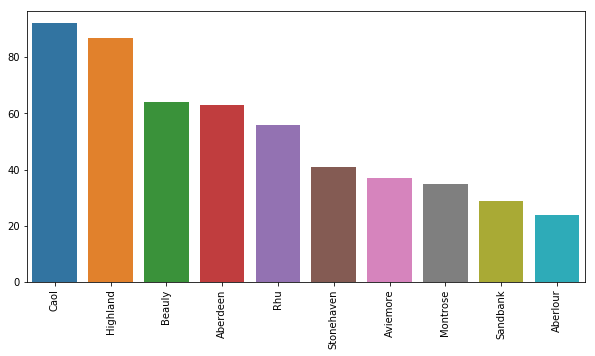

In [163]:
plt.figure(figsize=(10,5))
values = metadata_df['city'].value_counts()[:10]
sns.barplot(x = values.index.values, y = values.values)
plt.xticks(rotation=90)
plt.show()

In [164]:
top_towns = list(values.index.values)
top_towns

['Caol',
 'Highland',
 'Beauly',
 'Aberdeen',
 'Rhu',
 'Stonehaven',
 'Aviemore',
 'Montrose',
 'Sandbank',
 'Aberlour']

Caol is located near Fort William and as such is very picturesque - no wonder the most images throughout the dataset were taken here!

With the large number of towns/cities with insignificant numbers of images when compared to the top ten (greater than 20 images), it is worth only selecting the top n cities with a similar number of images. This avoids biasing the training of our dataset.

#### Visualise an example image from each of the top ten towns / cities

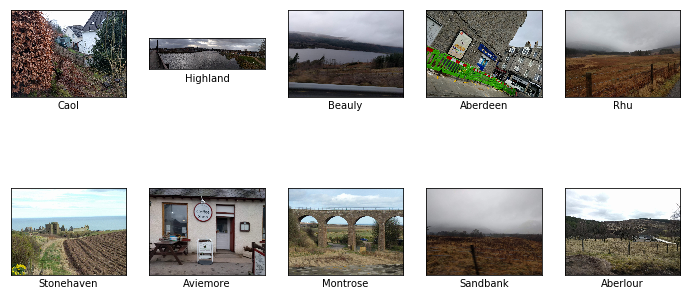

In [165]:
fig = plt.figure(figsize=(12, 6))

for i, example in enumerate(top_towns):
    
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    class_imgs = metadata_df[metadata_df['city'] == example]
    example_img_path = class_imgs.iloc[0]['filepath']
    
    example_img = imread(example_img_path)
    
    ax.imshow(example_img)
    
    ax.set_xlabel(example)

In the following section, we'll plot the locations of all images on a map of Scotland to give us an appreciation of the variation of geographical images we have within the dataset.

### Annotate image locations on a map of Scotland using Folium

###### Plot all points, regardless of location:

In [166]:
def plot_data_coords(row):
    folium.Circle(location=[row.latitude, row.longitude],
                  color='crimson',
                  tooltip = "<h5 style='text-align:center;font-weight: bold'>Img Name : "+row.filename+"</h5>"+
                            "<hr style='margin:10px;'>"+
                            "<ul style='color: #444;list-style-type:circle;align-item:left;"+
                            "padding-left:20px;padding-right:20px'>"+
                            "<li>Town : "+str(row.city)+"</li>"+
                            "<li>Lat : "+str(row.latitude)+"</li>"+
                            "<li>Long : "+str(row.longitude)+"</li>"+
                            "<li>Altitude : "+str(row.altitude)+"</li>"+
                            "<li>Time date : "+str(row.time_date)+"</li></ul>",
                  radius=20, weight=6).add_to(m)

    
m = folium.Map(location=[metadata_df['latitude'].mean(), 
                         metadata_df['longitude'].mean()], 
               tiles='OpenStreetMap',
               min_zoom=7, max_zoom=12, zoom_start=7.5)


# iterate through all rows and plot coords
metadata_df.apply(plot_data_coords, axis = 1)

m

###### Plot top ten town / city locations, with a different colour for each on the map:

In [167]:
colors = ['red', 'blue', 'gray', 'darkred', 'black', 'orange', 'beige', 'green', 
          'purple', 'lightgreen', 'darkblue', 'lightblue', 'darkgreen', 'darkpurple',
          'lightred', 'cadetblue', 'lightgray', 'pink']

# dict comp to form unique color for each town
town_colors = { town : color for town, color in zip(top_towns, colors[:len(top_towns)]) }

# select only data containing our selected towns / cities
top_towns_df = metadata_df[metadata_df['city'].isin(top_towns)]

In [168]:
def plot_top_towns(row):
    
    marker_colour = town_colors[row['city']]
    
    folium.Circle(location=[row.latitude, row.longitude],
                  color=marker_colour,
                  tooltip = "<h5 style='text-align:center;font-weight: bold'>Img Name : "+row.filename+"</h5>"+
                            "<hr style='margin:10px;'>"+
                            "<ul style='color: #444;list-style-type:circle;align-item:left;"+
                            "padding-left:20px;padding-right:20px'>"+
                            "<li>Town : "+str(row.city)+"</li>"+
                            "<li>Lat : "+str(row.latitude)+"</li>"+
                            "<li>Long : "+str(row.longitude)+"</li>"+
                            "<li>Altitude : "+str(row.altitude)+"</li>"+
                            "<li>Time date : "+str(row.time_date)+"</li></ul>",
                  radius=20, weight=6).add_to(m)
    
m = folium.Map(location=[top_towns_df['latitude'].mean(), 
                         top_towns_df['longitude'].mean()], 
               tiles='OpenStreetMap',
               min_zoom=7, max_zoom=12, zoom_start=7.5)

# iterate through all rows and plot coords
top_towns_df.apply(plot_top_towns, axis = 1)

m

### Save both of our dataframes for use later

In [169]:
metadata_df.to_csv("image_metadata.csv")
top_towns_df.to_csv("chosen_towns.csv")

### Show the collection of images over time using plotly (TO-DO)

In [170]:
#fig = px.scatter_geo(formated_gdf, locations="Country/Region", locationmode='country names', 
#                     color="Confirmed", size='size', hover_name="Country/Region", 
#                     range_color= [0, max(formated_gdf['Confirmed'])+2], 
#                     projection="natural earth", animation_frame="Date", 
#                     title='Spread over time')
#fig.update(layout_coloraxis_showscale=False)
#fig.show()

### Processing data into a form suitable for deep learning

Since all the images were taken in Scotland, it is not feasible to classify images by Country, since they are all the same. However, a potential option is to train a model to classify by County, City or Town. Another option could be to classify location based on location proximity, which could be achieved using a clustering algorithm to assign labels.

For this work, we'll classify images based on the town the image was taken in. This will be achieved by selected only the top n towns analysed above. Before we can do this, we need to further process our data. This will involve the following steps: 

1. Seperate our data according to the classification we want - in this case, we'll seperate the data by the town the image was taken in. This should be simple using the existing meta-data dataframe we created earlier.

2. Creation of a new set of directories: training, validation and test. Each of these directories will require n sub-directories for each of the n class labels (towns).

3. Selection of splits for training, validation and testing from the original dataset, and movement of these into the applicable new directories created in the previous step.

4. Pre-processing our data with the following: conversion from JPEG into RGB pixel grids formatted as floating-point tensors, rescaling and standardisation of our image pixel values so that they lie between 0 and 1.

The formatting of our data needs to be organised into a specific directory format so that we can apply useful tools such as data augmentation and transformations to our data prior to feeding into a machine learning model.

###### Form directory and sub-directory folders:

In [171]:
# obtain our data classes (output labels) using top towns from the data
classes = [town.lower() for town in top_towns]

# set location of our original image data from Kaggle
dataset_dir = os.path.join(os.getcwd(), 'Images')

# create our new directories - pathlib Path to avoid preexisting errors
base_dir = os.path.join(os.getcwd(), 'Base_Data')
Path(base_dir).mkdir(parents=True, exist_ok=True)
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# form each of the dirs above
for directory in [train_dir, validation_dir, test_dir]:
    Path(directory).mkdir(parents=True, exist_ok=True)
    
# create sub-directories for each town class for train, val and test dirs
for town_class in classes:
    # create sub-directories within training directory
    current_train_dir = os.path.join(train_dir, town_class)
    Path(current_train_dir).mkdir(parents=True, exist_ok=True)
    
    # repeat for validation dir
    current_val_dir = os.path.join(validation_dir, town_class)
    Path(current_val_dir).mkdir(parents=True, exist_ok=True)
    
    # repeat for test dir
    current_test_dir = os.path.join(test_dir, town_class)
    Path(current_test_dir).mkdir(parents=True, exist_ok=True)
    
# create training, validation and test splits for all images using the file paths
X_path = top_towns_df['filepath'].values
y = top_towns_df['city'].values

# first split - training + validation split combined, and seperate test split.
X_train_val_paths, X_test_paths, y_train, y_test = train_test_split(X_path, y, 
                                                                    test_size=0.1, 
                                                                    random_state=1, 
                                                                    stratify=y)

# second split - training and validation data
X_train_paths, X_val_paths, y_train, y_val = train_test_split(X_train_val_paths, 
                                                              y_train, 
                                                              test_size=0.25, 
                                                              random_state=1, 
                                                              stratify=y_train)

###### Form splits of our data using the file paths obtained for each image in the meta-data dataframe previously.

In [172]:
# create training, validation and test splits for all images using the file paths
X_path = top_towns_df['filepath'].values
y = top_towns_df['city'].values

# first split - training + validation split combined, and seperate 10% test split.
X_train_val_paths, X_test_paths, y_train, y_test = train_test_split(X_path, y, 
                                                                    test_size=0.1, 
                                                                    random_state=1, 
                                                                    stratify=y)

# second split - 75% training and 25% validation data
X_train_paths, X_val_paths, y_train, y_val = train_test_split(X_train_val_paths, 
                                                              y_train, 
                                                              test_size=0.25, 
                                                              random_state=1, 
                                                              stratify=y_train)

###### Plot number of classes within each data split

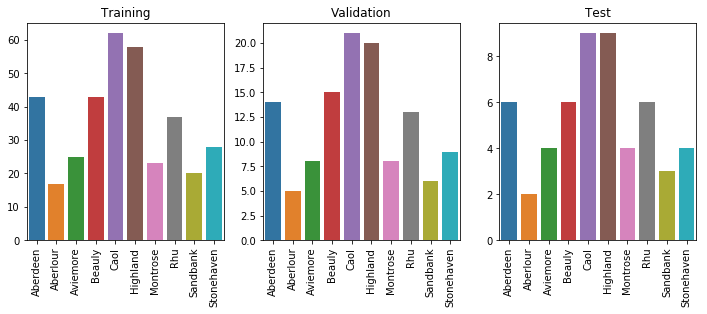

In [173]:
# get counts of class labels within each split
trg_towns, trg_counts =  np.unique(y_train, return_counts=True)
val_towns, val_counts =  np.unique(y_val, return_counts=True)
test_towns, test_counts =  np.unique(y_test, return_counts=True)

# plot number of classes within each data split for confirmation
fig = plt.figure(figsize=(12, 4))
split_types = ['Training', 'Validation', 'Test']

for i, data_split in enumerate([trg_counts, val_counts, test_counts]):
    
    ax = fig.add_subplot(1, 3, i+1)
    sns.barplot(x = trg_towns, y = data_split)
    plt.xticks(rotation=90)
    plt.title(split_types[i])

plt.show()

We're very limited with test cases for some of our classes (i.e. Aberlour and Sandbank). We're also not very well balanced, with some classes having many more images for training / testing compared to others. Despite these issues, this distribution of data for training, validation and testing will suffice for now.

###### Move images from original directory into associated training, validation and test directories

In [174]:
%%time

# copy training data
for i, img_location in enumerate(X_train_paths):
    class_label = y_train[i].lower()
    img_name = f"train_{i}.jpg"
    src_loc = img_location
    dest_loc = os.path.join(train_dir, class_label, img_name)
    
    # resize img and then move
    img = Image.open(src_loc)
    img_new = img.resize((504,378), Image.ANTIALIAS)
    img_new.save(dest_loc, 'JPEG', quality=90)
    
    # move img without resizing using shutil
    #_ = shutil.copyfile(src_loc, dest_loc)

# copy validation data
for i, img_location in enumerate(X_val_paths):
    class_label = y_val[i].lower()
    img_name = f"validation_{i}.jpg"
    src_loc = img_location
    dest_loc = os.path.join(validation_dir, class_label, img_name)
    
    # resize img and then move
    img = Image.open(src_loc)
    img_new = img.resize((504,378), Image.ANTIALIAS)
    img_new.save(dest_loc, 'JPEG', quality=90)
    
    #_ = shutil.copyfile(src_loc, dest_loc)
    
# copy test data
for i, img_location in enumerate(X_test_paths):
    class_label = y_test[i].lower()
    img_name = f"test_{i}.jpg"
    src_loc = img_location
    dest_loc = os.path.join(test_dir, class_label, img_name)
    
    # resize img and then move
    img = Image.open(src_loc)
    img_new = img.resize((504,378), Image.ANTIALIAS)
    img_new.save(dest_loc, 'JPEG', quality=90)
    
    #_ = shutil.copyfile(src_loc, dest_loc)

CPU times: user 2min 37s, sys: 3.19 s, total: 2min 41s
Wall time: 2min 54s


###### Data preprocessing and augmentation of our images using Keras ImageDataGenerator

In [175]:
img_height, img_width = 299, 299
batch_size = 10

# training data augmentation - rotate, shear, zoom and flip
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale = 1.0 / 255.0,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip=True)

# no augmentation for test data - only rescale
test_datagen = ImageDataGenerator(rescale = 1. / 255.0)

# generate batches of augmented data from training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

# generate val data from val dir
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

nb_train_samples = len(train_generator.classes)
nb_validation_samples = len(validation_generator.classes)

# create pandas dataframes for our train data
training_data = pd.DataFrame(train_generator.classes, columns=['classes'])
testing_data = pd.DataFrame(validation_generator.classes, columns=['classes'])

Found 356 images belonging to 10 classes.
Found 119 images belonging to 10 classes.


---
## 2. Baseline - Histogram of Oriented Gradients (HOG) Prediction Model

HOG is a conventional feature engineering and machine learning preprocessing technique for computer vision. This technique does not capture as many abstractions from an image when compared to superior methods such as convolutional neural networks, however it will do to serve as a basic baseline for this exercise.

#### Perform HOG on a single example

Shape: (3024, 4032, 3)


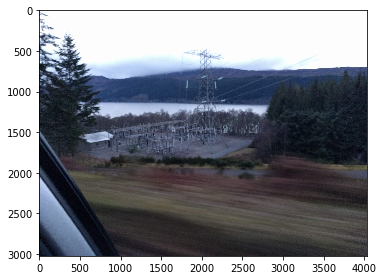

In [176]:
example_filename = 'Images/300-399/321.jpg'

# read our example img and display
example_img = imread(example_filename)
imshow(example_img)
print(f"Shape: {example_img.shape}")

As shown, the size of this image is huge, and as such is not ideal for use for our machine learning models in its current state. Thus, we'll need to resize the image, followed by extracting our HOG features:

In [177]:
# this image is much too large - resize suitably for HOG: 64 x 128
img_resized = resize(example_img, (128, 64)) 

# create our HOG features for example image using skimage HOG function
fd, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True, block_norm='L2-Hys')

/Users/benjaminfraser/miniconda2/envs/mypython3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning:

The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.

/Users/benjaminfraser/miniconda2/envs/mypython3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning:

Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.



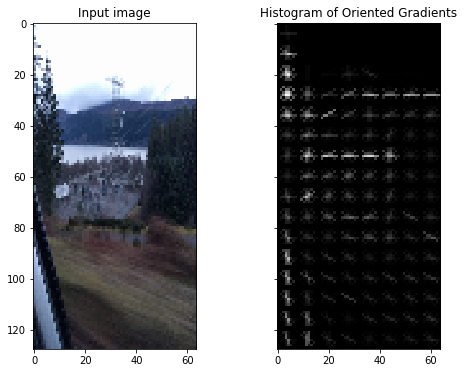

HOG Feature shape: (3780,)


In [178]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharex=True, sharey=True) 

ax1.imshow(img_resized, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

print(f"HOG Feature shape: {fd.shape}")

Good, we can now apply this to our entire set of images and form a baseline model.

In [179]:
## TO-DO: form a function to perform HOG for our data
##        This will need to be implemented after forming the dataset above...

In [180]:
# resize all images to 64 x 128, since we'll divide each image into 8x8 and 16x16 patches for the features

---
## 3. Training of a Convolutional Neural Network

We need to take our dataset of jpeg images and preprocess them accordingly prior to use in our deep learning model. In summary, we need to perform the following:

- Read in each of our images as a jpeg file
- Decode each image into floating-point tensor form, with RGB grids of pixels for each image
- Standardise our images through rescaling of the pixel values.

These functions are performed automatically using the data generators we created previously. For our first convolutional neural network, we'll form a custom smaller sized ConvNet.

In [181]:
def create_CNN():
    """ Basic CNN with 4 Conv layers, each followed by a max pooling """
    cnn_model = Sequential()
    
    # four Conv layers with max pooling
    cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
    cnn_model.add(MaxPooling2D(2, 2))
    cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(2, 2))
    cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(2, 2))
    cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(2, 2))
    
    # flatten output and feed to dense layer, via dropout layer
    cnn_model.add(Flatten())
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(512, activation='relu'))
    
    # add output layer - softmax with 10 outputs
    cnn_model.add(Dense(10, activation='softmax'))
    
    cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return cnn_model

In [182]:
CNN_model = create_CNN()
CNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 33, 33, 128)      

###### NOTE - only train once, and import model thereafter due to extremely long training time

In [183]:
# batch steps before an epoch is considered complete (trg_size / batch_size):
steps_per_epoch = np.ceil(nb_train_samples/batch_size)

# validation batch steps (val_size / batch_size):
val_steps_per_epoch = np.ceil(nb_validation_samples/batch_size)

In [184]:
#history = CNN_model.fit_generator(train_generator, epochs=25, 
#                                  validation_data=validation_generator, shuffle=True)

Save model and history data for later use:

In [185]:
# save model as a HDF5 file with weights + architecture
#CNN_model.save('models/Basic_CNN_model_1.h5')

In [186]:
# save the history of training to a datafile for later retrieval
#with open('models/train_history_basic_CNN_model_1.pickle', 'wb') as pickle_file:
#       pickle.dump(history.history, pickle_file)

###### Load model history and weights (after initial training completed on GPU)

In [187]:
# if already trained - import history file and training weights
CNN_model = load_model('models/Basic_CNN_model_1.h5')

In [188]:
# get history of trained model
with open('models/train_history_basic_CNN_model_1.pickle', 'rb') as handle:
    basic_cnn_history_1 = pickle.load(handle)

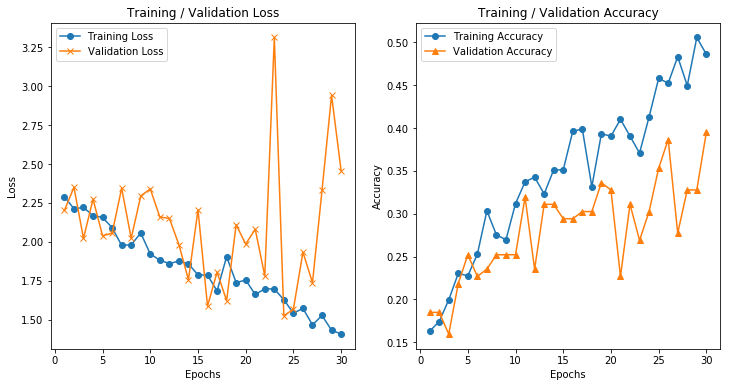

In [189]:
hist_dict_1 = basic_cnn_history_1

trg_loss = hist_dict_1['loss']
val_loss = hist_dict_1['val_loss']

trg_acc = hist_dict_1['accuracy']
val_acc = hist_dict_1['val_accuracy']

epochs = range(1, len(trg_acc) + 1)

# plot losses and accuracies for training and validation 
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(epochs, trg_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='x', label='Validation Loss')
plt.title("Training / Validation Loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend(loc='best')

ax = fig.add_subplot(1, 2, 2)
plt.plot(epochs, trg_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='^', label='Validation Accuracy')
plt.title("Training / Validation Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend(loc='best')
plt.show()

###### Evaluate on the test dataset

In [190]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(299, 299), 
                                                  batch_size=4, class_mode='categorical')

test_loss, test_accuracy = CNN_model.evaluate_generator(test_generator)
print(f"Test accuracy: {test_accuracy}")

Found 53 images belonging to 10 classes.
Test accuracy: 0.5660377144813538


50% is not bad, considering we have 10 different classes! Clearly, there is still a lot of improvement for our model though. One potential option could be to perform transfer learning and fine-tuning of an existing high-performing CNN, such as Xception, Inception, VGG19 or ResNet50. This will be formed in the next section.

---
## 4. Improving our model using transfer learning

For this we'll obtain a highly trained convolutional base using an existing xception network. We'll take this and train additional layers on top tailored to our image geolocation problem, which should hopefully provide a boost to the performance obtained from the simple ConvNet produced ealier.

In [191]:
from keras.applications import xception

In [192]:
# create our pretrained convolutonal base from xception
conv_base = xception.Xception(weights='imagenet', include_top=False)
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

We've only imported the xception network without its top fully-connected layers, since we want to design our own final layers suitable for our geolocation problem. 

We need to ensure that we have frozen all the existing layers of the Xception model, which is highly trained on the pre-existing imagenet data.

In [193]:
for layer in conv_base.layers:
  layer.trainable = False

In [194]:
tl_xception = Sequential()

# add pre-trained xception base
tl_xception.add(conv_base)

# flatten and add dense layer, with dropout
tl_xception.add(GlobalAveragePooling2D())
tl_xception.add(Dropout(0.5))
tl_xception.add(Dense(256, activation='relu'))

# output softmax, with 10 classes
tl_xception.add(Dense(10, activation='softmax'))

tl_xception.compile(loss='categorical_crossentropy', 
                    optimizer='adam', 
                    metrics=['accuracy'])

Lets set up checkpointing to save the best performance found on the val dataset:

In [195]:
# set up a check point for our model - save only the best val performance
save_path ="tl_xception_1_best_weights.hdf5"

trg_checkpoint = ModelCheckpoint(save_path, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')

trg_callbacks = [trg_checkpoint]

###### **Only run the following once on a GPU - after this just import the training weights and history file to avoid having to re-train.**

In [196]:
# batch steps before an epoch is considered complete (trg_size / batch_size):
steps_per_epoch = np.ceil(nb_train_samples/batch_size)

# validation batch steps (val_size / batch_size):
val_steps_per_epoch = np.ceil(nb_validation_samples/batch_size)

#history = tl_xception.fit(train_generator, epochs=25, 
#                          steps_per_epoch=steps_per_epoch, 
#                          validation_data=validation_generator, 
#                          validation_steps=val_steps_per_epoch,
#                          callbacks=trg_callbacks,
#                          shuffle=True)

In [197]:
# save model as a HDF5 file with weights + architecture
#tl_xception.save('tl_xception_1_model.h5')

# save the history of training to a datafile for later retrieval
#with open('tl_xception_history_1.pickle', 
#          'wb') as pickle_file:
#        pickle.dump(history.history, pickle_file)

If already trained and we have an existing weight and history file, run the following:

In [198]:
# if already trained - import history file and training weights
tl_xception = load_model('models/tl_xception_1_model.hdf5')

# get history of trained model
with open('models/tl_xception_history_1.pickle', 'rb') as handle:
    history = pickle.load(handle)

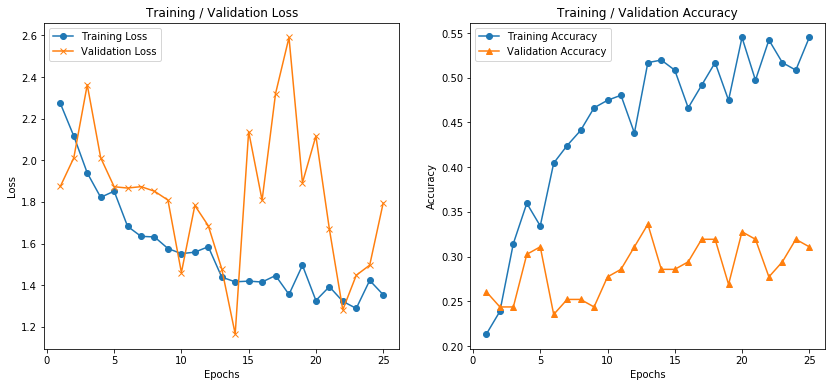

In [199]:
hist_dict_2 = history

trg_loss = hist_dict_2['loss']
val_loss = hist_dict_2['val_loss']

trg_acc = hist_dict_2['accuracy']
val_acc = hist_dict_2['val_accuracy']

epochs = range(1, len(trg_acc) + 1)

# plot losses and accuracies for training and validation 
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(epochs, trg_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='x', label='Validation Loss')
plt.title("Training / Validation Loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend(loc='best')

ax = fig.add_subplot(1, 2, 2)
plt.plot(epochs, trg_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='^', label='Validation Accuracy')
plt.title("Training / Validation Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend(loc='best')
plt.show()

###### Evaluate on the test dataset

In [200]:
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(299, 299), 
                                                  batch_size=5, 
                                                  class_mode='categorical')

test_loss, test_accuracy = tl_xception.evaluate(test_generator, steps=10)
print(f"Test accuracy: {test_accuracy}")

Found 53 images belonging to 10 classes.
10/10 [==============================] - 17s 2s/step
Test accuracy: 0.3199999928474426


This more complex model actually performs worse than the initial ConvNet produced. Its likely that with some further work, research and tinkering of the transfer learning model the performance could be made much better.

In addition, we could perform fine-tuning of the actual Convolutional Layers within the Xception (or other chosen base convolutional layer network). This would allow our model to better generalise to the types of images we are using within the geolocation dataset.

All things considered, we are always going to struggle to effectively classify with this dataset due to the limited number of training samples. Through collection of many more geolocated images with a wider range of examples and locations, I'm sure we could produce a much more impressive model.

## 5. Visualising some predictions from the test set with our model(s)

To decode one-hot encoded predictions back into class labels, we need to create a lookup dictionary from the decoded class labels, as follows:

In [201]:
# get class labels dict containing index of each class for decoding predictions
class_labels = train_generator.class_indices

# obtain a reverse dict to convert index into class labels
reverse_class_index = {i : class_label for class_label, i in class_labels.items()}

For convenience, we'll also form some basic functions for preprocessing and making predictions with new images:

In [202]:
def process_and_predict_img(image_path, model):
    """ Utility function for making predictions for an image. """
    img_path = image_path
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = test_datagen.standardize(x)
    predictions = model.predict(x)
    return img, predictions

For interest, we can also get back the top n predictions to see how certain (or uncertain) or model was in making a given prediction:

In [203]:
def top_n_predictions(predict_probs, top_n_labels=3):
    """ Obtain top n prediction indices for array of predictions """
    top_indices = np.argpartition(predict_probs[0], -top_n_labels)[-top_n_labels:]
    
    # negate prediction array to sort in descending order
    sorted_top = top_indices[np.argsort(-predict_probs[0][top_indices])]
    
    # dict comp to create dict of labels and probs
    labels = {"label_" + str(i + 1) : (reverse_class_index[index].capitalize(), 
                                       predict_probs[0][index]) for i, index in enumerate(sorted_top)}
    return labels

###### Prediction on a single example from the test set

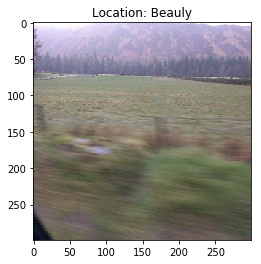

Top predictions:
- Beauly: 58.61%
- Caol: 24.79%
- Sandbank: 7.24%


In [229]:
img, prediction = process_and_predict_img(test_dir + '/caol/test_26.jpg', 
                                          model=tl_xception)
top_labels = top_n_predictions(prediction, 
                               top_n_labels=3)
plt.imshow(img)
plt.title(f"Location: {top_labels['label_1'][0]}")
plt.show()

print("Top predictions:")
for label in top_labels:
    print("- {0}: {1:.2f}%".format(top_labels[label][0], top_labels[label][1] * 100))

###### Prediction on a range of random examples from the test set using the Xception Transfer Learning Model:

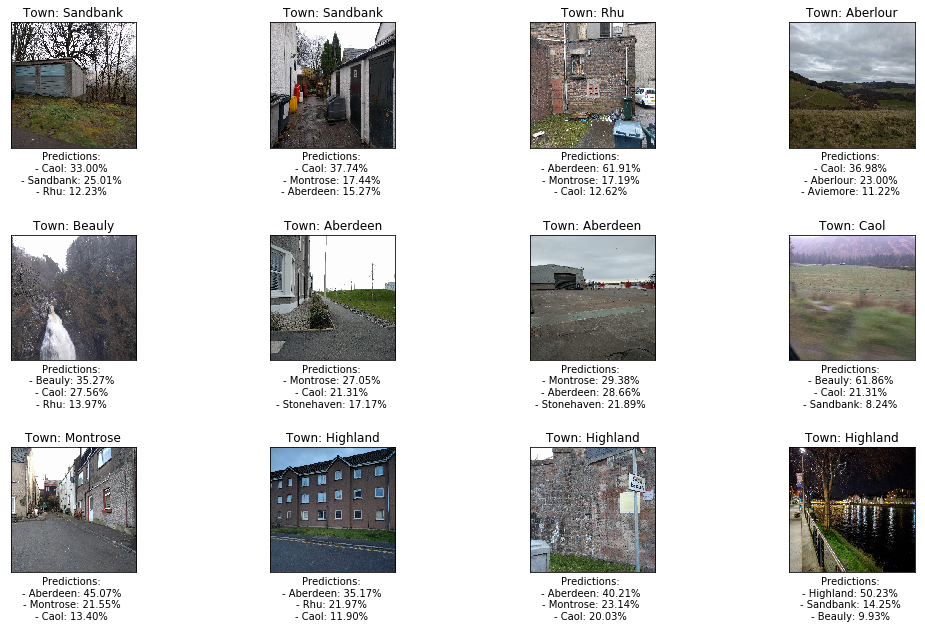

In [230]:
example_test_i = np.random.permutation(len(y_test))[:12]
example_test_img = X_test_paths[example_test_i]
example_test_y = y_test[example_test_i]

# create fig to display 12 different predictions
fig = plt.figure(figsize=(15,9))
img_num = 0

for i in range(12):
    ax = fig.add_subplot(3, 4, img_num + 1)
    
    img_path = example_test_img[img_num]
    
    # make prediction on image - select desired model (e.g. CNN_basic, or tl_xception)
    img, predictions = process_and_predict_img(img_path, model=tl_xception)
    top_labels = top_n_predictions(predictions, top_n_labels=3)
    
    prediction_string = ""
    for label in top_labels:
        prediction_string += f"- {top_labels[label][0]}: {top_labels[label][1]*100:.2f}% \n"
    
    ax.imshow(img)
    
    #title = reverse_class_index[np.argmax(predictions,axis=-1)[0]].capitalize()
    ax.set_title(f"Town: {example_test_y[img_num]}")
    ax.set_xlabel(f"Predictions: \n{prediction_string}")
    ax.set_xticks([])
    ax.set_yticks([])
    
    img_num += 1

plt.tight_layout()
plt.show()

###### Lets predict on the same examples, but using the original Basic CNN model:

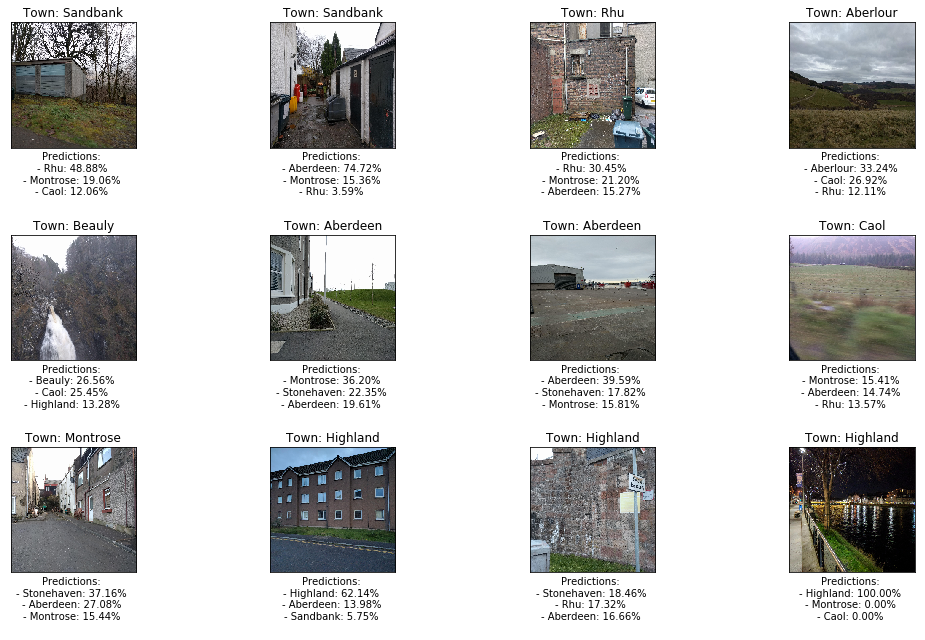

In [231]:
# create fig to display 12 different predictions
fig = plt.figure(figsize=(15,9))
img_num = 0

for i in range(12):
    ax = fig.add_subplot(3, 4, img_num + 1)
    
    img_path = example_test_img[img_num]
    
    # make prediction on image - select desired model (e.g. CNN_basic, or tl_xception)
    img, predictions = process_and_predict_img(img_path, model=CNN_model)
    top_labels = top_n_predictions(predictions, top_n_labels=3)
    
    prediction_string = ""
    for label in top_labels:
        prediction_string += f"- {top_labels[label][0]}: {top_labels[label][1]*100:.2f}% \n"
    
    ax.imshow(img)
    
    #title = reverse_class_index[np.argmax(predictions,axis=-1)[0]].capitalize()
    ax.set_title(f"Town: {example_test_y[img_num]}")
    ax.set_xlabel(f"Predictions: \n{prediction_string}")
    ax.set_xticks([])
    ax.set_yticks([])
    
    img_num += 1

plt.tight_layout()
plt.show()